<a href="https://colab.research.google.com/github/Lalith2005reddy/HDR_Image_Segmentation/blob/main/Ev_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-9cff79db7742>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


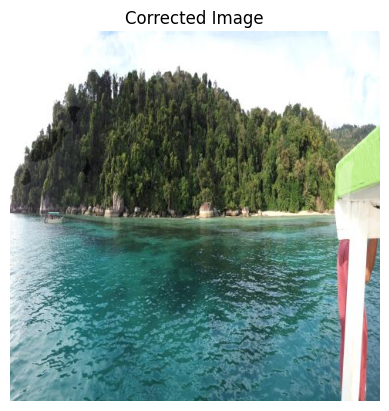

Average EV correction for overexposed regions: -0.0042
Average EV correction for underexposed regions: -0.1236


In [3]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Function to apply gamma correction
def apply_gamma_correction(image, gamma):
    """
    Applies gamma correction to an image.
    """
    gamma_corrected = np.power(image, gamma)
    return np.clip(gamma_corrected, 0, 1)

# Function to calculate the corrected exposure value (EV)
def calculate_corrected_ev(segmentation_mask, original_image):
    """
    Calculates the corrected EV for overexposed and underexposed regions
    based on the predicted segmentation mask.
    """
    # Convert original image to numpy array and normalize to [0, 1] range
    original_image = np.array(original_image) / 255.0

    # Get the overexposed and underexposed regions
    overexposed_mask = segmentation_mask == 1
    underexposed_mask = segmentation_mask == 2

    # Apply gamma correction
    gamma_overexposed = 0.7  # Gamma < 1 to reduce exposure for overexposed regions
    gamma_underexposed = 1.5  # Gamma > 1 to increase exposure for underexposed regions

    corrected_image = original_image.copy()

    # Correct overexposed regions
    corrected_image[overexposed_mask] = apply_gamma_correction(original_image[overexposed_mask], gamma_overexposed)

    # Correct underexposed regions
    corrected_image[underexposed_mask] = apply_gamma_correction(original_image[underexposed_mask], gamma_underexposed)

    # Visualize the corrected image
    plt.imshow(corrected_image)
    plt.title("Corrected Image")
    plt.axis('off')
    plt.show()

    # Estimate average EV change
    overexposed_correction = np.mean(original_image[overexposed_mask] - corrected_image[overexposed_mask])
    underexposed_correction = np.mean(corrected_image[underexposed_mask] - original_image[underexposed_mask])

    print(f"Average EV correction for overexposed regions: {overexposed_correction:.4f}")
    print(f"Average EV correction for underexposed regions: {underexposed_correction:.4f}")

# Function to predict and analyze an image for EV correction
def predict_and_correct_ev(image_path, model, transform):
    """
    Predicts the segmentation mask for an image and calculates corrected EV values
    for overexposed and underexposed regions.
    """
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image_tensor)['out']

    # Get the predicted mask (argmax over the class dimension)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Calculate the corrected EV for the segmented regions
    calculate_corrected_ev(predicted_mask, image)

# Load pre-trained DeepLabv3 model with ResNet-101 backbone and custom classifier
def load_model(model_path):
    """
    Loads the DeepLabv3 model from the specified file path, ignoring any
    unexpected keys such as aux_classifier.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=False)
    model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Modify for 3 classes

    # Load the model weights, ignoring unexpected keys
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    return model

# Example usage
model_path = '/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'  # Specify the path to your model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(model_path)

# Define the transform
transform = transforms.Compose([transforms.Resize((480, 480)),
                                transforms.ToTensor()])

# Path to the test image
image_path = '/content/drive/MyDrive/Dataset_phase5/test/test_img/img_-39-_exposure1-5_gamma1-5_jpg.rf.d7cf80ea1a11e85dc3332b3e834f210a.jpg'  # Path to the test image

# Analyze a single image for EV correction
predict_and_correct_ev(image_path, model, transform)

<ipython-input-11-731cb6b87df7>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


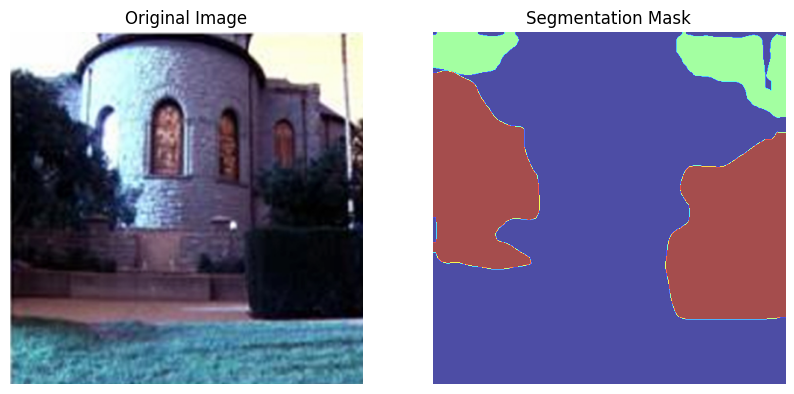

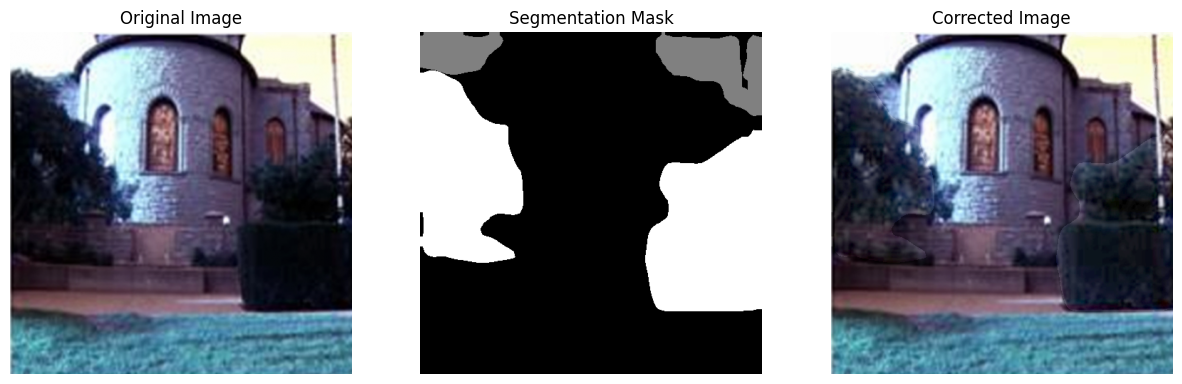

Average EV correction for overexposed regions: 0.0160
Average EV correction for underexposed regions: 0.0771


In [11]:
import torch
import numpy as np
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Function to apply gamma correction
def apply_gamma_correction(image, gamma):
    """
    Applies gamma correction to an image.
    """
    gamma_corrected = np.power(image, gamma)
    return np.clip(gamma_corrected, 0, 1)

# Function to calculate the corrected exposure value (EV)
def calculate_corrected_ev(segmentation_mask, original_image):
    """
    Calculates the corrected EV for overexposed and underexposed regions
    based on the predicted segmentation mask.
    """
    # Resize the original image to match the segmentation mask's dimensions
    original_image = ImageOps.fit(original_image, segmentation_mask.shape[::-1])  # Resize the original image
    original_image = np.array(original_image) / 255.0  # Normalize to [0, 1] range

    # Get the overexposed and underexposed regions
    overexposed_mask = segmentation_mask == 1
    underexposed_mask = segmentation_mask == 2

    # Correct exposure based on region type
    gamma_overexposed = 1.5  # Gamma > 1 to darken the overexposed regions
    gamma_underexposed = 0.7  # Gamma < 1 to brighten the underexposed regions

    corrected_image = original_image.copy()

    # Correct overexposed regions (darken)
    corrected_image[overexposed_mask] = apply_gamma_correction(original_image[overexposed_mask], gamma_overexposed)

    # Correct underexposed regions (brighten)
    corrected_image[underexposed_mask] = apply_gamma_correction(original_image[underexposed_mask], gamma_underexposed)

    # Display the original image, segmentation mask, and corrected image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(corrected_image)
    plt.title("Corrected Image")
    plt.axis('off')

    plt.show()

    # Estimate average EV change
    overexposed_correction = np.mean(original_image[overexposed_mask] - corrected_image[overexposed_mask])
    underexposed_correction = np.mean(corrected_image[underexposed_mask] - original_image[underexposed_mask])

    print(f"Average EV correction for overexposed regions: {overexposed_correction:.4f}")
    print(f"Average EV correction for underexposed regions: {underexposed_correction:.4f}")


# Load pre-trained DeepLabv3 model with ResNet-101 backbone and custom classifier
def load_model(model_path):
    """
    Loads the DeepLabv3 model from the specified file path, ignoring any
    unexpected keys such as aux_classifier.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=False)
    model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Modify for 3 classes

    # Load the model weights, ignoring unexpected keys
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    return model

# Example usage
model_path = '/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'  # Specify the path to your model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(model_path)

# Define the transform
transform = transforms.Compose([transforms.Resize((480, 480)),
                                transforms.ToTensor()])

# Path to the test image
image_path = '/content/drive/MyDrive/paper_imgs/paper_img_4.png'  # Path to the test image

# Analyze a single image for EV correction
predict_and_correct_ev(image_path, model, transform)

<ipython-input-18-c20d7d315dde>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


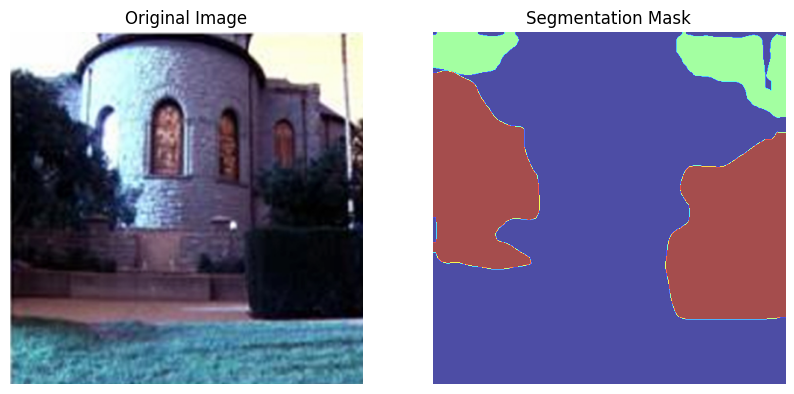

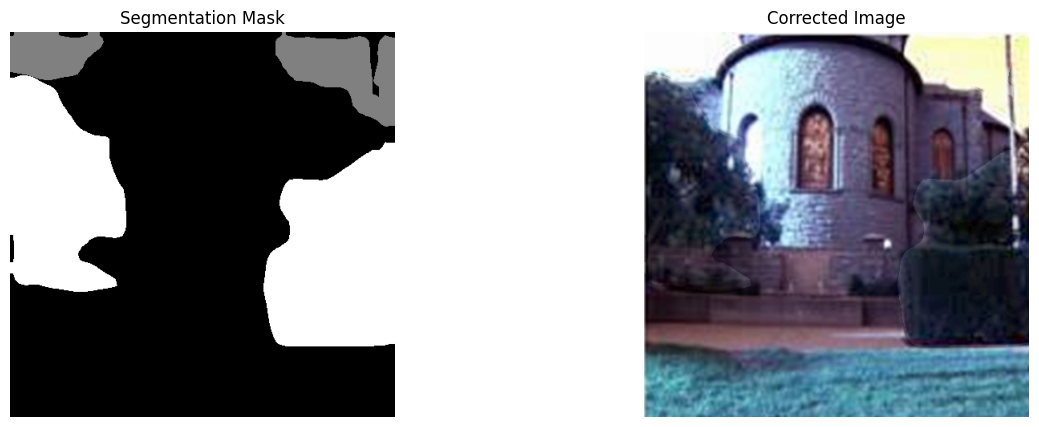

Average EV correction for overexposed regions: 0.0310
Average EV correction for underexposed regions: 0.0771


In [18]:
import torch
import numpy as np
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Function to apply gamma correction
def apply_gamma_correction(image, gamma):
    """
    Applies gamma correction to an image.
    """
    gamma_corrected = np.power(image, gamma)
    return np.clip(gamma_corrected, 0, 1)

# Function to calculate the corrected exposure value (EV)
def calculate_corrected_ev(segmentation_mask, original_image):
    """
    Calculates the corrected EV for overexposed and underexposed regions
    based on the predicted segmentation mask.
    """
    # Resize the original image to match the segmentation mask's dimensions
    original_image = ImageOps.fit(original_image, segmentation_mask.shape[::-1])  # Resize the original image
    original_image = np.array(original_image) / 255.0  # Normalize to [0, 1] range

    # Get the overexposed and underexposed regions
    overexposed_mask = segmentation_mask == 1
    underexposed_mask = segmentation_mask == 2

    # Correct exposure based on region type
    gamma_overexposed = 2.0  # Increased gamma to darken the overexposed regions more
    gamma_underexposed = 0.7  # Gamma < 1 to brighten the underexposed regions

    corrected_image = original_image.copy()

    # Correct overexposed regions (darken)
    corrected_image[overexposed_mask] = apply_gamma_correction(original_image[overexposed_mask], gamma_overexposed)

    # Correct underexposed regions (brighten)
    corrected_image[underexposed_mask] = apply_gamma_correction(original_image[underexposed_mask], gamma_underexposed)

    # Display the segmentation mask and corrected image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(segmentation_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(corrected_image)
    plt.title("Corrected Image")
    plt.axis('off')

    plt.show()

    # Estimate average EV change
    overexposed_correction = np.mean(original_image[overexposed_mask] - corrected_image[overexposed_mask])
    underexposed_correction = np.mean(corrected_image[underexposed_mask] - original_image[underexposed_mask])

    print(f"Average EV correction for overexposed regions: {overexposed_correction:.4f}")
    print(f"Average EV correction for underexposed regions: {underexposed_correction:.4f}")

# Function to predict and analyze an image for EV correction
def predict_and_correct_ev(image_path, model, transform):
    """
    Predicts the segmentation mask for an image and calculates corrected EV values
    for overexposed and underexposed regions. Displays the original image and mask.
    """
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image_tensor)['out']

    # Get the predicted mask (argmax over the class dimension)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.7)  # Use colormap for better visualization
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.show()

    # Calculate and visualize the corrected EV for the segmented regions
    calculate_corrected_ev(predicted_mask, image)

# Load pre-trained DeepLabv3 model with ResNet-101 backbone and custom classifier
def load_model(model_path):
    """
    Loads the DeepLabv3 model from the specified file path, ignoring any
    unexpected keys such as aux_classifier.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=False)
    model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Modify for 3 classes

    # Load the model weights, ignoring unexpected keys
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    return model

# Example usage
model_path = '/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'  # Specify the path to your model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(model_path)

# Define the transform
transform = transforms.Compose([transforms.Resize((480, 480)),
                                transforms.ToTensor()])

# Path to the test image
image_path = '/content/drive/MyDrive/paper_imgs/paper_img_4.png'  # Path to the test image

# Analyze a single image for EV correction
predict_and_correct_ev(image_path, model, transform)

<ipython-input-29-36b3da381986>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


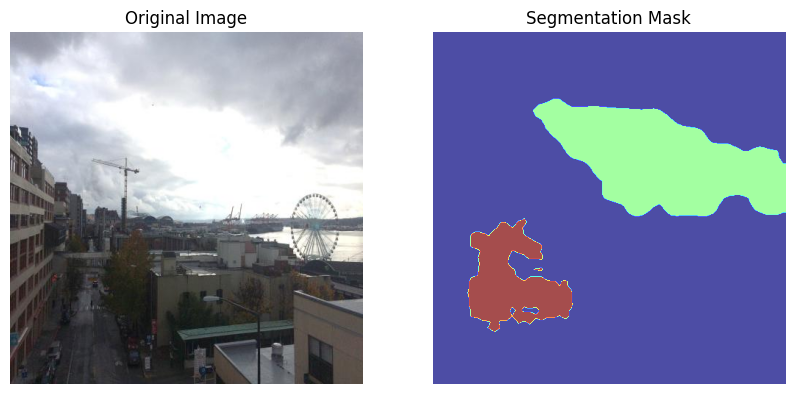

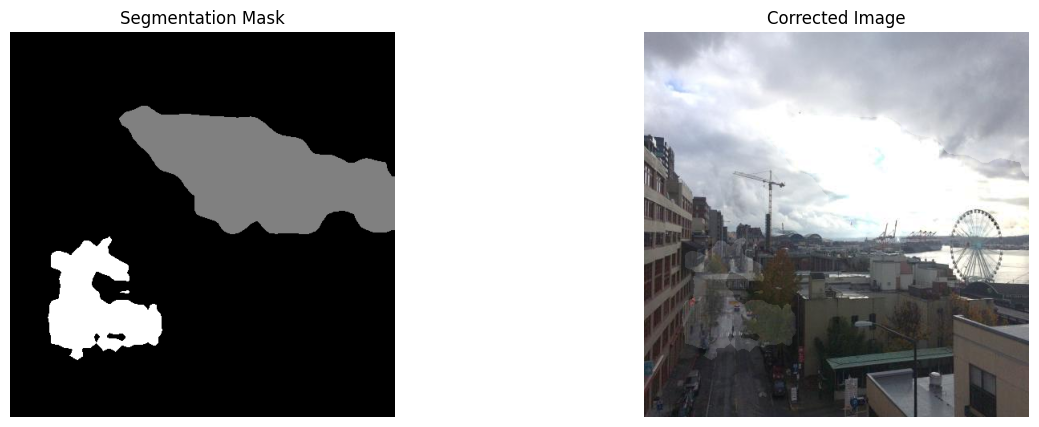

Average EV correction for overexposed regions: 0.0300
Average EV correction for underexposed regions: 0.3466


In [29]:
import torch
import numpy as np
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Function to apply gamma correction
def apply_gamma_correction(image, gamma):
    """
    Applies gamma correction to an image.
    """
    gamma_corrected = np.power(image, gamma)
    return np.clip(gamma_corrected, 0, 1)

# Function to calculate the corrected exposure value (EV) changes
def calculate_corrected_ev(segmentation_mask, original_image):
    """
    Calculates the corrected EV for overexposed and underexposed regions
    based on the predicted segmentation mask.
    """
    # Resize the original image to match the segmentation mask's dimensions
    original_image = ImageOps.fit(original_image, segmentation_mask.shape[::-1])  # Resize the original image
    original_image = np.array(original_image) / 255.0  # Normalize to [0, 1] range

    # Get the overexposed and underexposed regions
    overexposed_mask = segmentation_mask == 1
    underexposed_mask = segmentation_mask == 2

    # Correct exposure based on region type
    gamma_overexposed = 2.0  # Increased gamma to darken the overexposed regions more
    gamma_underexposed = 0.7  # Gamma < 1 to brighten the underexposed regions

    corrected_image = original_image.copy()

    # Correct overexposed regions (darken)
    corrected_image[overexposed_mask] = apply_gamma_correction(original_image[overexposed_mask], gamma_overexposed)

    # Correct underexposed regions (brighten)
    corrected_image[underexposed_mask] = apply_gamma_correction(original_image[underexposed_mask], gamma_underexposed)

    # Display the segmentation mask and corrected image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(segmentation_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(corrected_image)
    plt.title("Corrected Image")
    plt.axis('off')

    plt.show()

    # Estimate average EV change
    overexposed_correction = np.mean(original_image[overexposed_mask] - corrected_image[overexposed_mask])
    underexposed_correction = np.mean(corrected_image[underexposed_mask] - original_image[underexposed_mask])

    # Convert mean corrections to EV change estimates
    ev_change_overexposed = (overexposed_correction) * 3  # Arbitrary scaling for demonstration
    ev_change_underexposed = (underexposed_correction) * 3  # Arbitrary scaling for demonstration

    print(f"Average EV correction for overexposed regions: {ev_change_overexposed:.4f}")
    print(f"Average EV correction for underexposed regions: {ev_change_underexposed:.4f}")

# Function to predict and analyze an image for EV correction
def predict_and_correct_ev(image_path, model, transform):
    """
    Predicts the segmentation mask for an image and calculates corrected EV values
    for overexposed and underexposed regions. Displays the original image and mask.
    """
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image_tensor)['out']

    # Get the predicted mask (argmax over the class dimension)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.7)  # Use colormap for better visualization
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.show()

    # Calculate and visualize the corrected EV for the segmented regions
    calculate_corrected_ev(predicted_mask, image)

# Load pre-trained DeepLabv3 model with ResNet-101 backbone and custom classifier
def load_model(model_path):
    """
    Loads the DeepLabv3 model from the specified file path, ignoring any
    unexpected keys such as aux_classifier.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=False)
    model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Modify for 3 classes

    # Load the model weights, ignoring unexpected keys
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    return model

# Example usage
model_path = '/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'  # Specify the path to your model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(model_path)

# Define the transform
transform = transforms.Compose([transforms.Resize((480, 480)),
                                transforms.ToTensor()])

# Path to the test image
image_path = '/content/drive/MyDrive/Dataset_phase5/test/test_img/img_-50-_exposure1-5_gamma1-5_jpg.rf.b3b78d9ebad88b02b07337fbe257d51a.jpg'  # Path to the test image

# Analyze a single image for EV correction
predict_and_correct_ev(image_path, model, transform)